In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numdifftools as nd
from scipy.interpolate import interp1d

In [2]:
import modules.plots.deconvolution as dec_plots
import modules.experimental_rir as exprir
from modules import randomized_ir, utils, mcmc, adc

from modules_reloader import reloader
relmod = reloader(dec_plots, exprir, randomized_ir, utils, mcmc, adc)

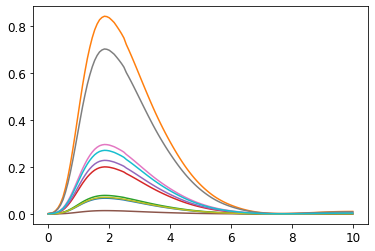

In [3]:
ir_t, ir_shape = exprir.read_ir_shape()
ir_t, ir_shape = exprir.cut_ir_shape(ir_t, ir_shape, excluded_integral_percentile=0.02)

rir = randomized_ir.RandomizedIr(ir_x=ir_t, ir_y=ir_shape, factor=exprir.generate_C_pmt)
L = rir.L

rir.plot_realizations()

In [4]:
N = 35

n_vec_lambda = 20
n_vec = utils.generate_poissonian_ns(n_vec_lambda, N)

# injecting fake signal in 3 central bins
n_vec[ N//2-1 : N//2+2  ] += 2*n_vec_lambda

adc_step = 2.0

s_vec = adc.adc_accepted_s_vec(rir.convolve_with_n_vec(n_vec), adc_step)

In [5]:
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10**6)

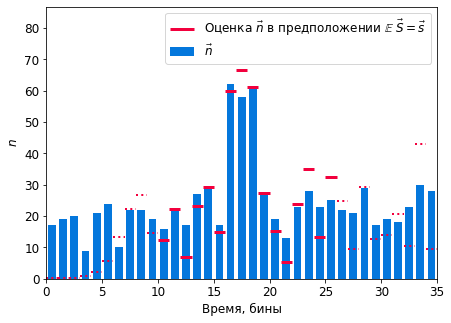

In [6]:
n_vec_estimation = rireff.estimate_n_vec(s_vec, delta=adc_step)
f, a = dec_plots.plot_mean_n_estimation(n_vec, n_vec_estimation, L)

In [7]:
ll_fact = rireff.get_loglikelihood_independent_normdist(s_vec, delta=adc_step, density=False)
ll_fact(n_vec_estimation)  # let the numba do the trick
ll_mvn_density = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=True)
ll_mvn = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=False)

In [8]:
for ll_timed in [utils.timer(lambda *a, **kw: '')(ll) for ll in (ll_fact, ll_mvn_density, ll_mvn)]:
    print(ll_timed(n_vec_estimation))

loglikelihood_normdist() took 9.424999007023871e-06 seconds to complete.
-22.005581191996455
loglikelihood_mvn() took 0.000765838998631807 seconds to complete.
-26.124177267262983
loglikelihood_mvn() took 0.00405224700079998 seconds to complete.
-14.174934338832163


In [9]:
relmod()

In [10]:
result_preliminary = mcmc.run_mcmc(
    logposterior=ll_fact,
    init_point=n_vec_estimation,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=128,
        n_samples=20000,
        progress_bar=True,
        # autocorr_estimation_each=3000,
        # debug_acceptance_fraction_each=500,
    ) 
)

100%|██████████| 20000/20000 [00:14<00:00, 1404.07it/s]


In [11]:
tau = result_preliminary.sampler.get_autocorr_time(quiet=True).mean()

N/50 = 400;
tau: [2368.29340326 2439.8339474  2366.37133896 2230.76958558 1922.15078777
 1439.14881117 1466.81921982 1651.471592   1789.32931567 1885.82048972
 1561.06989305 1624.72627177 1516.22197432 1498.64389826 1536.92394351
 1553.55453978 1502.76572319 1491.0546748  1471.98166865 1469.31860104
 1472.25197775 1551.20988459 1536.39562749 1493.7144525  1585.5135014
 1488.15797484 1481.89084793 1532.73207157 1536.95705231 1545.74411107
 1464.96667064 1558.57313107 1491.3169342  1883.34851867 2092.0865286 ]


In [12]:
n_walkers_final = 128

init_pts = mcmc.extract_independent_sample(result_preliminary.sampler, desired_sample_size=n_walkers_final)

In [13]:
result = mcmc.run_mcmc(
    logposterior=ll_mvn,
    init_point=init_pts,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=n_walkers_final,
        n_samples=4 * tau,
        progress_bar=True,
        starting_points_strategy='given',
    )
)

100%|██████████| 6685/6685 [16:38<00:00,  6.69it/s]


In [14]:
sample_preliminary = mcmc.extract_independent_sample(result_preliminary.sampler, tau_override=tau, debug=True)
sample = mcmc.extract_independent_sample(result.sampler, tau_override=tau, debug=True)

Autocorrelation time is estimated at 1671.4608275533608 (ranges from 1671.4608275533608 to 1671.4608275533608)
Burn-in = 3342 samples
Thinning = 1504 samples
Autocorrelation time is estimated at 1671.4608275533608 (ranges from 1671.4608275533608 to 1671.4608275533608)
Burn-in = 3342 samples
Thinning = 1504 samples


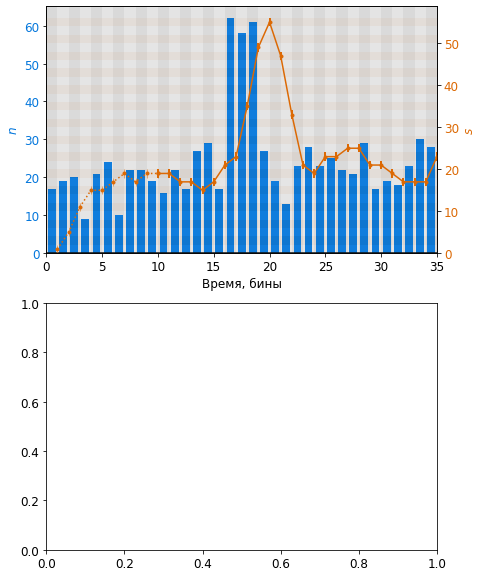

/home/njvh/Documents/Science/sphere/thesis/modules/plots/deconvolution.py:212: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(
<ipython-input-15-a008762f3b92>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_conv_solution.show()


In [15]:
fig_conv_solution, (ax_conv, ax_solution) = plt.subplots(nrows=2, figsize=dec_plots.Figsize.TWOPANEL_VERT.value)

dec_plots.plot_convolution(
    n_vec=n_vec, s_vec=s_vec, delta=adc_step, fig_ax=(fig_conv_solution, ax_conv), end_x_axis_on_N=True,
)

dec_plots.plot_bayesian_mean_estimation(n_vec, sample, L, n_vec_estimation, fig_ax=(fig_conv_solution, ax_solution))

fig_conv_solution.savefig('../doc/pic/final-problem-and-solution.pdf')

fig_conv_solution.show()

In [19]:
relmod()

(<Figure size 504x360 with 1 Axes>, <AxesSubplot:xlabel='$n_{17}$'>)

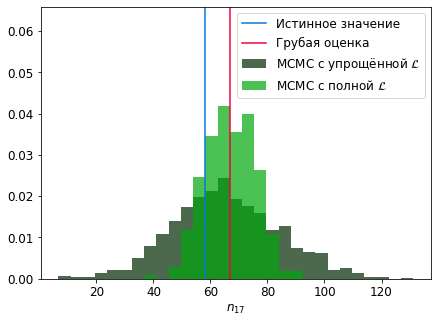

In [36]:
filename = 'simplified-and-true-likelihood-comparison'
# filename = None

dec_plots.plot_bayesian_mean_estimation_in_bin(
    n_vec,
    [sample_preliminary, sample],
    ['MCMC с упрощённой $\\mathcal{{L}}$', 'MCMC с полной $\\mathcal{{L}}$'],
    n_vec_estimation=n_vec_estimation,
    ibin=17,
    filename=filename
)